## 共享单车用户数预测

利用美国某共享单车公司2011/2012年数据，训练和测试一个模型，并对模型的性能和预测能力进行测试。
原始数据包括该公司收集到与共享单车业务相关的17个特征。
原始数据已经经过处理，存储为csv格式。

## 1.导入必要工具包

In [1]:
import numpy as np #矩阵处理
import pandas as pd #数据处理

from sklearn.metrics import r2_score # 评价回归预测模型的性能

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt #画图
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder # 数据标准化

from scipy.sparse import hstack

# 图形出现在Notebook里而不是新窗口
%matplotlib inline


## 2.数据探索
见文件　CBdata.ipynb

In [2]:
### 2.1 读取数据

In [3]:
# dapath = '/media/wyb/work/AI-learning/ai/week-00/ML-Capital-Bikeshare/dataset/'  # 数据文件路径

cb = pd.read_csv('../dataset/day.csv')  # 以csv格式读取数据

# print "cb　data type is %s" % cb.dtypes  # 输出各字段数据类型

cb.head()  # 打印文件头部内容，查看各字段前五列数据值
# print cb.tail()  # 打印数据尾部五个数据值


# 读取样本数目、特征维数每个特征的类型、空值样本数目、数据类型
# cb.shape



,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 2.2 数据准备

In [4]:
# 取出2011年数据作为训练数据,2012年作为测试数据
# train_data = cb[cb['yr'] == 0]

# test_data = cb[cb['yr'] ==1 ]
y = cb['cnt']

X = cb.drop(['dteday','instant','casual','registered','cnt'],axis=1)

# 训练数据与测试数据8/2分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 从训练数据中获取输入特征X和输出特征Y
#y_train = y_train['cnt'].values

#　删除暂时无关特征
# X_train = X_train.drop(['dteday','instant','casual','registered'],axis=1)

# X_test = X_test.drop(['dteday','instant','casual','registered'],axis=1)

# columns = X_test.columns

## 2.3 数据预处理/特征工程

### 2.3.1　数据预处理

In [6]:
OneHotEnc = OneHotEncoder()
mn_x = MinMaxScaler()

# 对训练数据中输入特征x中类别变量进行OneHotEncoder处理
x_train_cat = OneHotEnc.fit_transform(X_train[['season','mnth','holiday','weekday','workingday']])

#　数据值变量继续预处理
x_train_num = mn_x.fit_transform(X_train[['temp','atemp','hum','windspeed']])

# 将变换后的变量合到一起
x_train = hstack((x_train_cat, x_train_num))

# y_train = train_data['cnt'].values

In [7]:
# 对测试数据预处理
x_test_cat = OneHotEnc.transform(X_test[['season','mnth','holiday','weekday','workingday']])
x_test_num = mn_x.transform(X_test[['temp','atemp','hum','windspeed']])
x_test = hstack((x_test_cat, x_test_num))

# y_test = test_data['cnt'].values

### 3.确定模型类型
#### 3.1 尝试缺省参数的线性回归

In [18]:
#　线性回归
from sklearn.linear_model import LinearRegression

#使用默认配置初始化
lr = LinearRegression(copy_X=True)

# 训练模型参数
lr.fit(x_train, y_train)

#分别在训练集与测试集预测
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

print y_test_pred_lr.shape
print lr.coef_
print lr.intercept_

# 查看各特征权重，权重绝对值大小为该特征重要程度
# fs = pd.DataFrame({'columns':list(), "coef":list((lr.coef_.T))})
# fs.sort_values(by=['coef'], ascending=False)
# y_test_pred_lr

(147,)
[ -8.39797300e+02   1.08893550e+02  -2.34240817e+02   7.10602147e+02
   2.94388320e+02   2.96843135e+02   5.56606111e+02  -9.82832672e+01
   1.19563272e+02  -5.32088380e+02  -1.13626884e+03  -5.70787252e+02
   5.18199501e+02   2.61578610e+02  -1.02236296e+02   1.37942667e+02
   1.03477415e+02  -3.58019835e+02  -1.39289919e+02  -5.13611737e-01
  -1.49558561e+02  -1.31250092e+02  -1.87377800e+02   7.74289686e+01
   2.76018596e+02  -2.21291159e+02  -3.32512616e+01   5.74166319e+03
   5.07569110e+02  -4.04187663e+03  -1.59773811e+03]
4560.97773973


#### 3.1.1 模型评价

In [10]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of LinearRegression on test is',r2_score(y_test, y_test_pred_lr)

# 训练集
print 'The r2 score of LinearRegression on train is',r2_score(y_train, y_train_pred_lr)

The r2 score of LinearRegression on test is 0.511853760044
The r2 score of LinearRegression on train is 0.573943964507


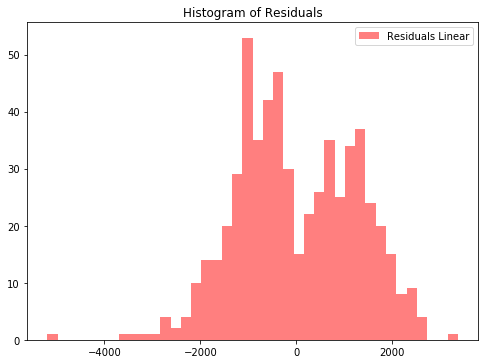

In [11]:
# 在训练集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_train - y_train_pred_lr, bins=40, label="Residuals Linear", color='red', alpha=.5)
ax.set_title("Histogram of Residuals")
ax.legend(loc='best')


### 3.2 Huber损失回归模型

In [12]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor()
huber.fit(x_train, y_train)

# 分别在训练集与测试集上预测 
y_train_pred_hb = huber.predict(x_train)
y_test_pred_hb = huber.predict(x_test)


### 3.2.1 模型评价

In [13]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of HuberRegression on test is',r2_score(y_test, y_test_pred_hb)

# 训练集
print 'The r2 score of HuberRegression on train is',r2_score(y_train, y_train_pred_hb)

The r2 score of HuberRegression on test is 0.506130465299
The r2 score of HuberRegression on train is 0.571341411898


## 4.岭回归，对正则参数lambda (scikit learn 中为alpha)调优

In [ ]:
from sklearn.linear_model import RidgeCV

#设置超参数范围
alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas = alphas)

In [20]:
# 模型训练
ridge.fit(x_train, y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000, 10000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [21]:
# 预测
y_test_pred_cv = ridge.predict(x_test)
y_train_pred_cv = ridge.predict(x_train)

In [22]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print (('the r2 score of RidgeCV on test is '), r2_score(y_test, y_test_pred_cv))
print (('the r2 score of RidgeCV on train is '), r2_score(y_train, y_train_pred_lr))

('the r2 score of RidgeCV on test is ', 0.51718721391135358)
('the r2 score of RidgeCV on train is ', 0.57394396450741625)


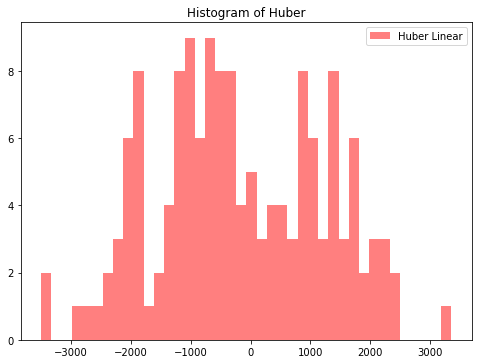

In [31]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_hb, bins=40, label="Huber Linear", color='red', alpha=.5)
ax.set_title("Histogram of Huber")
ax.legend(loc='best')

## 5. Lasso 模型

In [34]:
from sklearn.linear_model import LassoCV
#设置超参数范围
# alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000]
# lasso = LassoCV(alphas=alphas)
lasso = LassoCV()

In [35]:
lasso.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [ ]:
y_test_pred_lso = lasso.predict(x_test)
print (('the r2 score of Lasso on train is '), r2_score(y_test, y_test_pred_lso))
print (('the best alpha '), lasso.alpha_)

('the r2 score of Lasso on train is ', 0.52803956335185709)
('the best alpha ', 9.355245563589337)


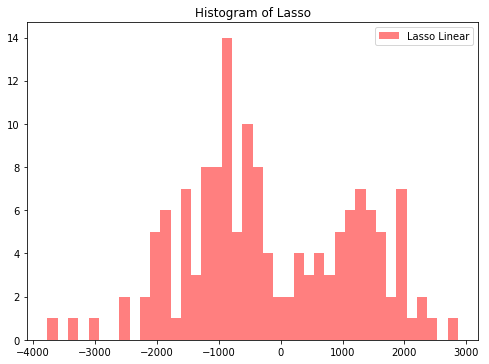

In [37]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_lso, bins=40, label="Lasso Linear", color='red', alpha=.5)
ax.set_title("Histogram of Lasso")
ax.legend(loc='best')